# Implementing a PINN to solve the 2D Paraxial Helmholtz equation

### The waveguide equation

The Paraxial Helmholtz equation (PHE) is given by

$\newcommand{\ppx}{\frac{\partial}{\partial x}}$
$\newcommand{\ppxz}{\frac{\partial^2}{\partial x^2}}$
$\newcommand{\ppxiz}{\frac{\partial^2}{\partial \xi^2}}$
$\newcommand{\ppz}{\frac{\partial^2}{\partial z}}$
$\newcommand{\ppze}{\frac{\partial^2}{\partial \zeta}}$
$\newcommand{\e}{\mathrm{e}}$
$\newcommand{\i}{\mathrm{i}}$

$$ \ppxz A(x,z) + 2 \i k \ppz A(x,z) - a^2 n_0^2 k_0^2 x^2 \, A(x,z) = 0. $$

### Reference solution: The Hermite-Gaussian modes

The reference solution is

$$ A(x,z) = \sum_n c_n g_n(x) \e^{-\frac{\i M_n}{2 n_0 k_0} z} $$

with

$$ M_n = 2 a n_0 k_0 \left(1 + \frac{1}{2}\right) $$

and

$$ g_n(x) = \frac{1}{\sqrt{2^n n!}} \left(\frac{a n_0 k_0}{\pi} \right)^{1/4} \e^{-\frac{a n_0 k_0 x^2}{2}} H_n\left((a n_0 k_0)^{1/2} x\right) $$

where $H_n(z)$ are the Hermite polynomials.

\begin{align}
H_{n+1} (z) &= 2 z H_n(z) - 2n H_{n-1} (z) \\
H_1(z) &= 2z \\
H_0(z) &= 1.
\end{align}

### Normalization

With $\xi = x / w_0$ and $\zeta = z / z_0$ with $z_0 = \frac{1}{2} n_0 k_0 w_0^2$ we receive

$$ \ppxiz A(\xi,\zeta) + 4 \i \ppze A(\xi,\zeta) - 4a^2z_0^2 \xi^2 \, A(\xi,\zeta) = 0$$

with solution

$$ A(\xi,\zeta) = \sum_n c_n g_n(\xi) \e^{-\frac{2 \i a n_0 k_0 \left(n+ \frac{1}{2}\right)}{2 n_0 k_0} z_0 \zeta} = \sum_n c_n g_n(\xi) \e^{-\i a z_0  \left(n + \frac{1}{2}\right) \zeta}$$

or expressed with $M_n$:

$$ A(\xi,\zeta) = \sum_n c_n g_n(\xi) \e^{- \i M_n \frac{n_0 k_0 w_0^2}{2} \frac{1}{2 n_0^2 k_0} \zeta} = \sum_n c_n g_n(\xi) \e^{- \i M_n \frac{  w_0^2}{4} \zeta} $$

where

$$ g_n(\xi) = \frac{1}{\sqrt{2^n n!}} \left(\frac{ a n_0 k_0}{\pi}\right)^{1/4} \e^{- az_0 \xi^2} H_n ( \sqrt{2 a z_0} \xi) $$

#### Boundary conditions

The $x$-boundaries are flexible; we choose Dirichlet conditions. The initial condition is

$$ A(\xi,\zeta=0) = \sum_n c_n g_n(\xi) $$

# Code

### Importing stuff

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from time import time
import deepxde as dde

2022-06-19 11:27:21.786376: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Using backend: tensorflow



### Setting seed, backend and other setup conveniences

In [2]:
dde.backend.set_default_backend('tensorflow')

Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax (all lowercase)


In [3]:
dde.optimizers.config.set_LBFGS_options(maxiter=100)

In [4]:
tf.config.run_functions_eagerly(True)

In [5]:
print(tf.version.VERSION)

2.5.0


In [6]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

In [7]:
plt.style.use('rc.mplstyle')

In [8]:
plt.rcParams['axes.grid'] = False   # otherwise he dislikes colorplots

In [9]:
tf.random.set_seed(42) # always the same seed - reproducibility

In [10]:
pi = tf.constant(np.pi, dtype=DTYPE) # everybody needs some pi in their life

2022-06-19 11:27:24.900363: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-06-19 11:27:24.935166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 11:27:24.935624: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce 940MX computeCapability: 5.0
coreClock: 1.189GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 37.33GiB/s
2022-06-19 11:27:24.935662: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-06-19 11:27:24.940243: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-06-19 11:27:24.940437: I tensorflow/stream_executor/platform

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Setting constants

In [12]:
number = 2

In [13]:
n_0 = 1.
k_0 = 2.
w_0 = 1.

z_0 = n_0 * k_0 * w_0**2 / 2

a = 1.
limit = 2

x_lb = -5.
x_ub = 5.
z_lb = 0.
z_ub = 1.

coeff_pre = np.zeros(limit).astype(np.complex64)
coeff_pre[0] = 1. + 2j
coeff_pre[1] = 0.3 + 4j
#coeff_pre[2] = 0.9 + 1j
#coeff_pre[3] = 3 + 4j
#coeff_pre[4] = 2 + 0.1j
coeff = coeff_pre / np.sqrt(np.sum(np.abs(coeff_pre)**2))

maxepoch = 12000
lbfgs_add = 2000
lr = 1e-3
phylr = [5e-4, 1., 1.]
num_layers = 5
num_nodes = 32
boundary_condition = 'dirichlet'

In [14]:
Nx = 10000   # Nx and Nt should be the same, else we
Nz = 10000   # get a ragged tensor and nobody wants that

N_test = 101

Nbx = 200   # these do not have to
Nbz = 200   # be the same size

In [15]:
coeffstring_pre = np.array2string(coeff_pre)
coeffstring = ''.join(coeffstring_pre)

with open(f'documentation/calc{number}.txt', 'w') as f:
    line0 = f'Documentation for Calculation {number}'
    line1 = 'Waveguide, unnormalized'
    line2 = f'Boundary condition: {boundary_condition}'
    line3 = f'Optimizer: Adam till {maxepoch}, L-BFGS from {maxepoch} to {maxepoch + lbfgs_add}'
    line4 = f'{num_layers} Layers and {num_nodes} nodes per layer'
    line5 = f'Learning rate is {lr}, residual weights is {phylr[0]}'
    line6 = f'Bound weight is {phylr[1]} and initial weight is {phylr[2]}'
    line7 = f'Highest n in initial wave is {limit}'
    line8 = f'Coefficients are {coeffstring} (unnormalized)'
    line9 = f'w_0 = {w_0} and a = {a} and z_0 = {z_0}'
    line10 = f'x_lb = {x_lb} and x_ub = {x_ub}'
    line11 = f'z_lb = {z_lb} and z_ub = {z_ub}'
    line12 = f'N = {Nx} and N_test = {N_test} and N_b / N_0 = {Nbx}'
    lines = '\n'.join([line0, line1, line2, line3, line4, line5, line6, line7, line8, line9, line10, line11, line12])
    f.write(lines)

### Mathematical functions

With $\xi = x / w_0$ and $\zeta = z / z_0$ with $z_0 = \frac{1}{2} n_0 k_0 w_0^2$ we receive

$$ \ppxiz A(\xi,\zeta) + 4 \i \ppze A(\xi,\zeta) - 4a^2z_0^2 \xi^2 \, A(\xi,\zeta) = 0$$

with solution

$$ A(\xi,\zeta) = \sum_n c_n g_n(\xi) \e^{-\frac{2 \i a n_0 k_0 \left(n+ \frac{1}{2}\right)}{2 n_0 k_0} z_0 \zeta} = \sum_n c_n g_n(\xi) \e^{-\i a z_0  \left(n + \frac{1}{2}\right) \zeta}$$

where

$$ g_n(\xi) = \frac{1}{\sqrt{2^n n!}} \left(\frac{ a n_0 k_0}{\pi}\right)^{1/4} \e^{- az_0 \xi^2} H_n ( \sqrt{2 a z_0} \xi) = \frac{1}{\sqrt{2^n n!}} \left(\frac{ 2 a z_0}{\pi w_0^2}\right)^{1/4} \e^{- az_0 \xi^2} H_n ( \sqrt{2 a z_0} \xi) $$

With $\xi = x / 10w_0$ and $\zeta = z / 10z_0$ with $z_0 = \frac{1}{2} n_0 k_0 w_0^2$ we receive

$$ \frac{1}{10}\ppxiz A(\xi,\zeta) + 4 \i \ppze A(\xi,\zeta) - 4000 a^2z_0^2 \xi^2 \, A(\xi,\zeta) = 0$$

with solution

$$ A(\xi,\zeta) = \sum_n c_n g_n(\xi) \e^{-10 \i a z_0  \left(n + \frac{1}{2}\right) \zeta}$$

where

$$ g_n(\xi) = \frac{1}{\sqrt{2^n n!}} \left(\frac{ 2 a z_0}{\pi w_0^2}\right)^{1/4} \e^{-100 az_0 \xi^2} H_n ( \sqrt{2 a z_0}10 \xi) $$

In [16]:
def hermite(z, n):
    if n == 1:
        return 2 * z
    elif n == 0:
        return 1
    else:
        return 2 * z * hermite(z, n-1) - 2 * (n-1) * hermite(z, n-2)

In [17]:
def g(x,n):
    pre1= 1 / np.sqrt( 2**n * float(np.math.factorial(n)))
    pre2 = ( 2 * a * z_0 / (np.pi * w_0**2)) **(0.25)
    gauss = np.exp(- a * z_0 * x**2)
    argument = np.sqrt(2 * a * z_0) * x
    return pre1 * pre2 * gauss * hermite(argument, n)

In [18]:
#def eigenvalue(n):
#    return k_0 * np.sqrt(8 * a * n_0) * (n + 0.5)

In [19]:
def phase(z,n):
    argument = - a * z_0 * (n + 0.5) * z
    return np.exp(argument * 1j)

In [20]:
def A_exact_np(x_ar, z_ar, coeff, limit):
    sol = np.empty((len(z_ar), len(x_ar))).astype(np.complex64)
    for i,x in enumerate(x_ar):
        for j,z in enumerate(z_ar):
            sol[j,i] = 0
            for n in range(limit):
                sol[j,i] += coeff[n] * g(x,n) * phase(z,n)
    return sol

In [21]:
def A_init(x_ar, coeff, limit):
    isol = np.empty(len(x_ar)).astype(np.complex64)
    for i,x in enumerate(x_ar):
        isol[i] = 0
        for n in range(limit):
            isol[i] += coeff[n] * g(x,n)
    return isol

### Plotting the solution beforehand

In [22]:
def u_exact_np(x, z):
    return np.real(A_exact_np(x,z,coeff,limit))

def v_exact_np(x, z):
    return np.imag(A_exact_np(x,z,coeff,limit))

def u_init(x0):
    x0_np = x0.numpy()
    u_np = np.real(A_init(x0_np,coeff,limit))
    u_tf_pre = tf.convert_to_tensor(u_np, dtype=DTYPE)
    u_tf = tf.reshape(u_tf_pre, [Nbz, 1])
    return u_tf

def v_init(x0):
    x0_np = x0.numpy()
    v_np = np.imag(A_init(x0_np,coeff,limit))
    v_tf_pre = tf.convert_to_tensor(v_np, dtype=DTYPE)
    v_tf = tf.reshape(v_tf_pre, [Nbz, 1])
    return v_tf

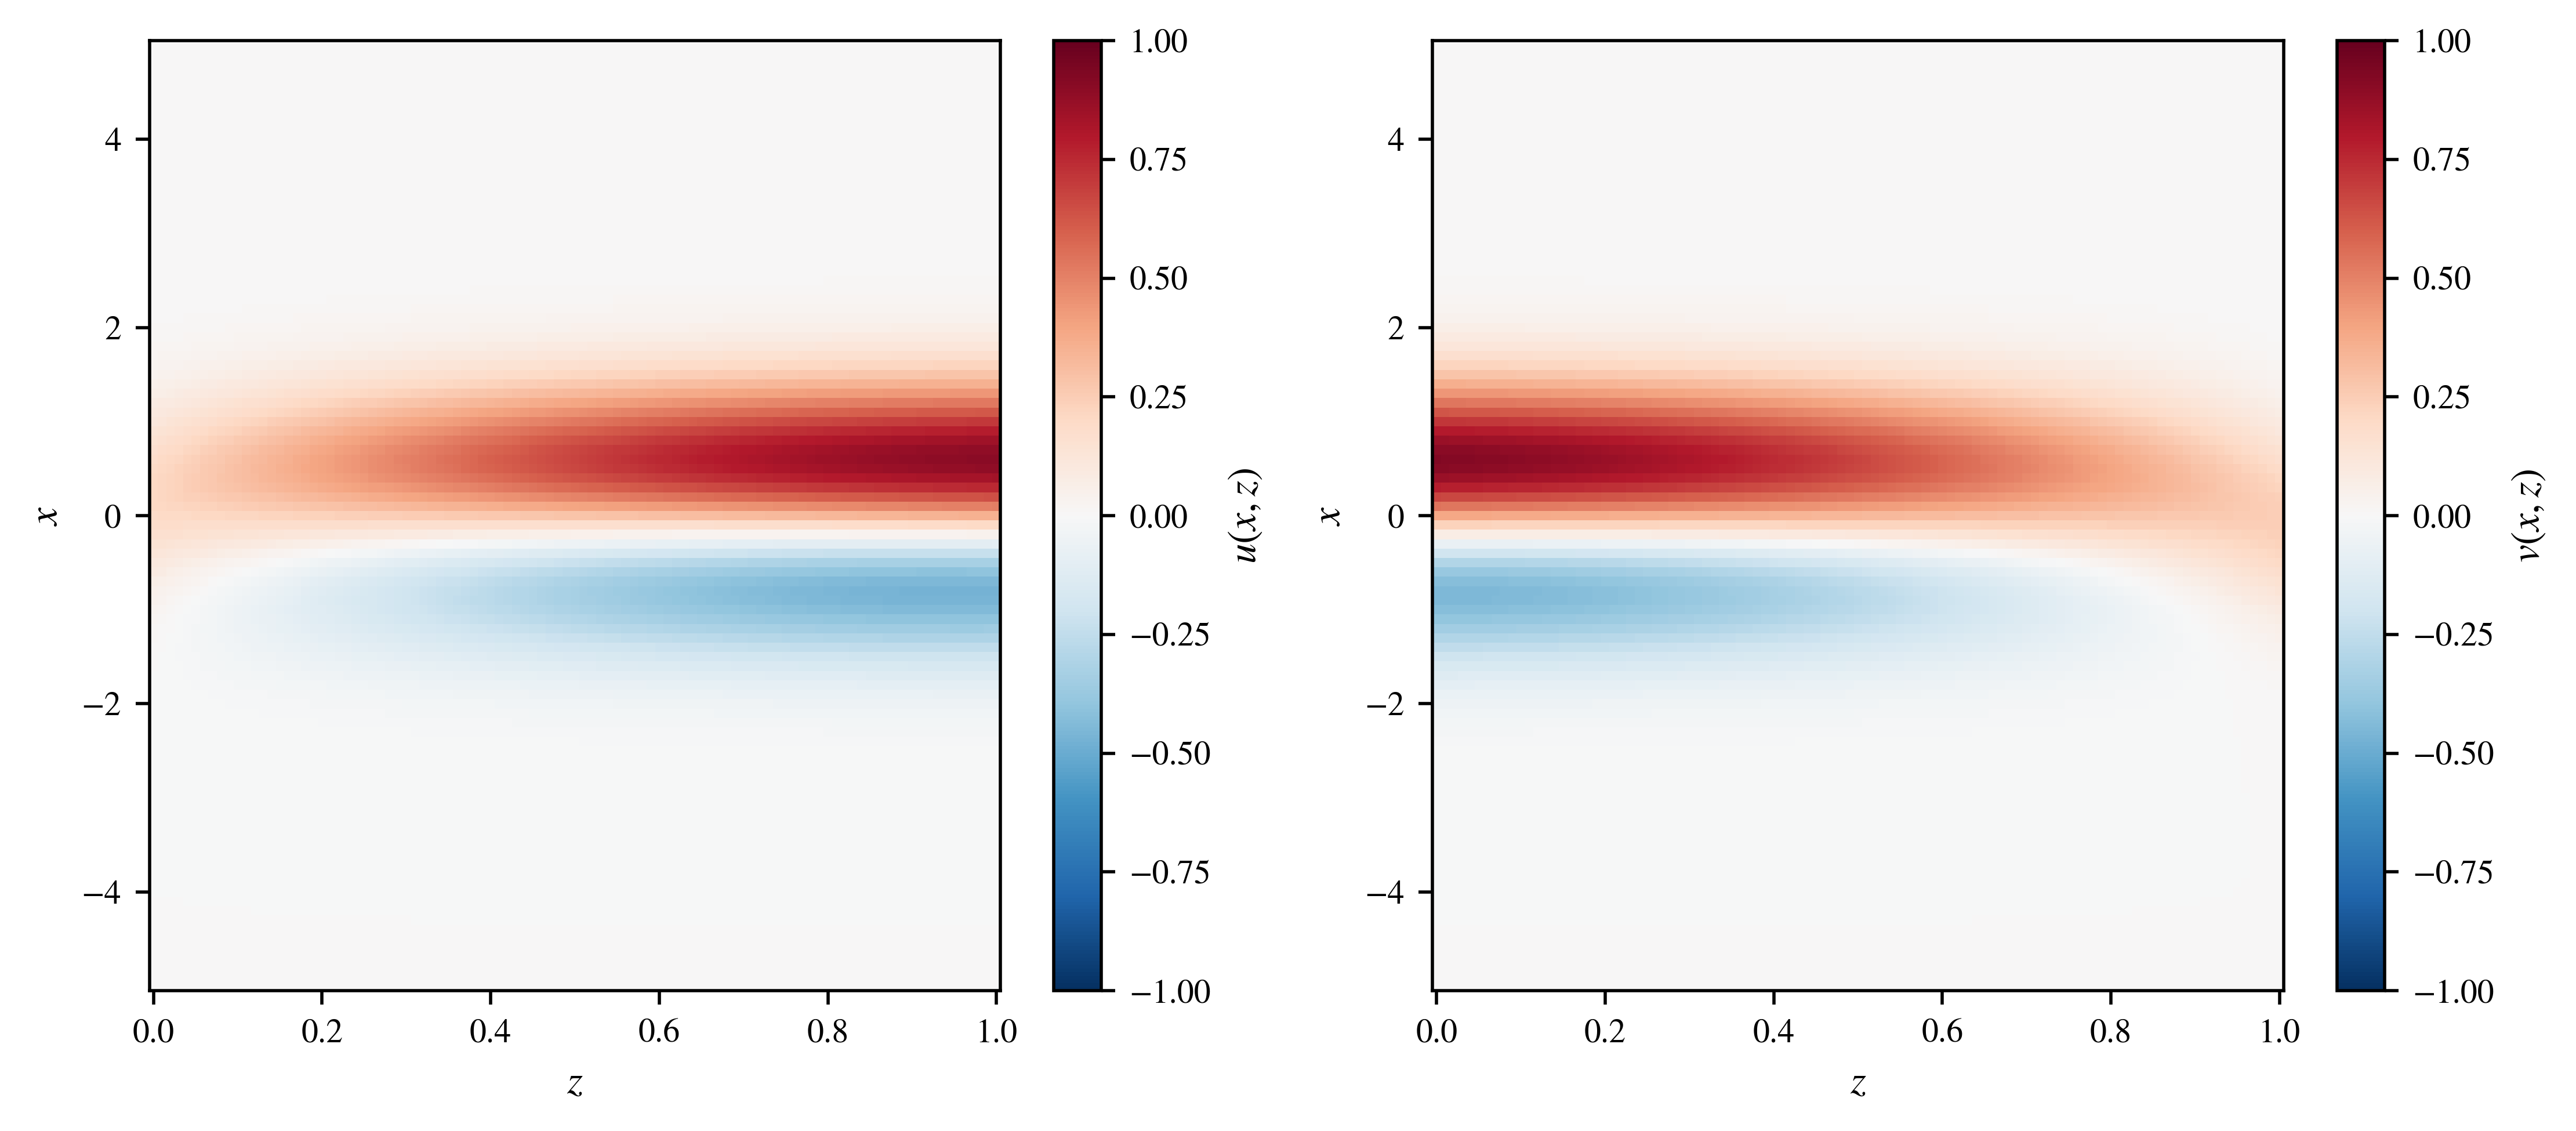

In [23]:
x_np = np.linspace(x_lb, x_ub, num=N_test)
z_np = np.linspace(z_lb, z_ub, num=N_test)

x_npmesh, z_npmesh = np.meshgrid(x_np, z_np)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4), dpi=500)

line1 = ax1.pcolormesh(z_npmesh, x_npmesh, u_exact_np(x_np, z_np), vmin=-1, vmax=1, cmap = cm.RdBu_r)
ax1.set_xlabel('$z$')
ax1.set_ylabel('$x$')
#ax1.set_title('exact solution of $u(x,z)$')
cmap1 = fig.colorbar(line1, ax=ax1)
cmap1.set_label('$u(x,z)$')

line2 = ax2.pcolormesh(z_npmesh, x_npmesh, v_exact_np(x_np, z_np), vmin=-1, vmax=1, cmap = cm.RdBu_r)
ax2.set_xlabel('$z$')
ax2.set_ylabel('$x$')
#ax2.set_title('exact solution of $v(x,z)$')
cmap2 = fig.colorbar(line2, ax=ax2)
cmap2.set_label('$v(x,z)$')

fig.tight_layout()
fig.savefig(f'epochs/reference_calc{number}.png')
    
plt.show()
plt.close()

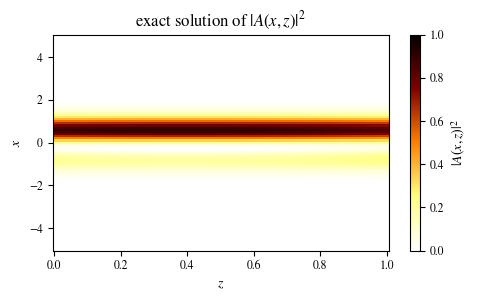

In [24]:
fig, ax1 = plt.subplots(1, dpi=100)
line1 = ax1.pcolormesh(z_npmesh, x_npmesh, np.abs(A_exact_np(x_np, z_np, coeff, limit))**2, vmin=0, vmax=1, cmap = cm.afmhot_r)
ax1.set_xlabel('$z$')
ax1.set_ylabel('$x$')
ax1.set_title('exact solution of $|A(x,z)|^2$')
cmap1 = fig.colorbar(line1, ax=ax1)
cmap1.set_label('$|A(x,z)|^2$')

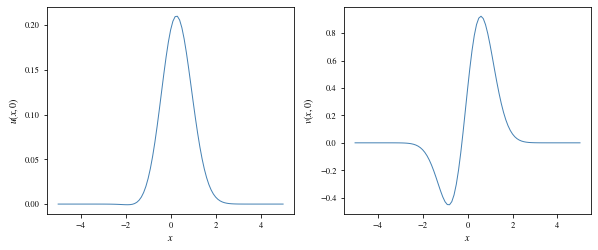

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))

ax1.plot(x_np, np.real(A_init(x_np, coeff, limit)))
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$u(x, 0)$')

ax2.plot(x_np, np.imag(A_init(x_np, coeff, limit)))
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$v(x, 0)$')
plt.show()
plt.close()

### Create all input

In [26]:
# x and z collocation points for PDE residual

x = tf.random.uniform((Nx, 1), x_lb, x_ub, dtype=DTYPE)
z = tf.random.uniform((Nz, 1), z_lb, z_ub, dtype=DTYPE)
XZ = tf.concat([x, z], axis=1)

xtest = np.linspace(x_lb, x_ub, N_test)
ztest = np.linspace(z_lb, z_ub, N_test)
xtestm, ztestm = np.meshgrid(xtest, ztest)
xtestm_resh = xtestm.flatten().reshape(N_test**2, 1)
ztestm_resh = ztestm.flatten().reshape(N_test**2, 1)

xtestm_resh_tf = tf.convert_to_tensor(xtestm_resh, dtype=DTYPE)
ztestm_resh_tf = tf.convert_to_tensor(ztestm_resh, dtype=DTYPE)
XZtest = tf.concat([xtestm_resh_tf, ztestm_resh_tf], axis=1)

# x and z for initial condition

z0 = tf.ones((Nbz, 1), dtype=DTYPE) * z_lb
x0 = tf.random.uniform((Nbz, 1), x_lb, x_ub, dtype=DTYPE)
XZ0 = tf.concat([x0, z0], axis=1)

# x and z for boundary conditions

zb = tf.random.uniform((Nbx, 1), z_lb, z_ub, dtype=DTYPE)
xlb = tf.ones((Nbx, 1), dtype=DTYPE) * x_lb
XZlb = tf.concat([xlb, zb], axis=1)
xub = tf.ones((Nbx, 1), dtype=DTYPE) * x_ub
XZub = tf.concat([xub, zb], axis=1)

### Function to initialize model

In [27]:
def init_model(L,N):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(2))
    for _ in range(L):
        model.add(tf.keras.layers.Dense(N,
                                       activation=tf.keras.activations.get('tanh'), # why not ReLu?
                                       kernel_initializer='glorot_normal')) # why not random?
    model.add(tf.keras.layers.Dense(2)) # 2d output (u and v)
    return model

### Function to return the PDE residuals ("physics")

$$ \ppxiz A(\xi,\zeta) + 4 \i \ppze A(\xi,\zeta) - 4a^2z_0^2 \xi^2 \, A(\xi,\zeta) = 0$$


In [28]:
def physics_dirichlet():
    with tf.GradientTape(persistent=True) as tape:
        x_phy, z_phy = XZ[:, 0:1], XZ[:, 1:2]
        
        tape.watch(x_phy)
        tape.watch(z_phy)
        
        A_phy = model((tf.stack([x_phy[:,0], z_phy[:,0]], axis=1)))
        
        u_phy = A_phy[:, 0:1]
        v_phy = A_phy[:, 1:2]
        
        u_dx = tape.gradient(u_phy, x_phy)
        v_dx = tape.gradient(v_phy, x_phy)
        
    u_dz = tape.gradient(u_phy, z_phy)
    u_dx2 = tape.gradient(u_dx, x_phy)
    v_dz = tape.gradient(v_phy, z_phy)
    v_dx2 = tape.gradient(v_dx, x_phy)
    
    del tape
      
    real_resid = u_dx2 - (4 * a**2 * z_0**2) * x_phy**2 * u_phy - 4 * v_dz
    imag_resid = v_dx2 - (4 * a**2 * z_0**2) * x_phy**2 * v_phy + 4 * u_dz

    return real_resid, imag_resid

### Function to compute loss

In [29]:
u0_exact = u_init(XZ0[:,0:1]) 
v0_exact = v_init(XZ0[:,0:1]) 

In [30]:
def compute_loss_dirichlet_adam():
    real_resid, imag_resid = physics_dirichlet()
    
    A_init_pred = model(XZ0)
    A_lb_pred = model(XZlb)
    A_ub_pred = model(XZub)
    
    u_init_pred = A_init_pred[:, 0:1]
    u_lb_pred = A_lb_pred[:, 0:1]
    u_ub_pred = A_ub_pred[:, 0:1]
    
    v_init_pred = A_init_pred[:, 1:2]
    v_lb_pred = A_lb_pred[:, 1:2]
    v_ub_pred = A_ub_pred[:, 1:2]
    
    real_phi_pde = tf.reduce_mean(tf.square(real_resid)) * phylr[0]
    u_phi_lb = tf.reduce_mean(tf.square(u_lb_pred)) * phylr[1]
    u_phi_ub = tf.reduce_mean(tf.square(u_ub_pred)) * phylr[1]
    u_phi_i = tf.reduce_mean(tf.square(u0_exact - u_init_pred)) * phylr[2]
    
    imag_phi_pde = tf.reduce_mean(tf.square(imag_resid)) * phylr[0]
    v_phi_lb = tf.reduce_mean(tf.square(v_lb_pred)) * phylr[1]
    v_phi_ub = tf.reduce_mean(tf.square(v_ub_pred)) * phylr[1]
    v_phi_i = tf.reduce_mean(tf.square(v0_exact - v_init_pred)) * phylr[2]
    
    u_phi_bound = u_phi_lb + u_phi_ub
    v_phi_bound = v_phi_lb + v_phi_ub
    
    loss = real_phi_pde + imag_phi_pde + u_phi_bound + u_phi_i + v_phi_bound + v_phi_i
        
    return loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i

In [31]:
def compute_loss_dirichlet_lbfgs():
    real_resid, imag_resid = physics_dirichlet()
    
    A_init_pred = model(XZ0)
    A_lb_pred = model(XZlb)
    A_ub_pred = model(XZub)
    
    u_init_pred = A_init_pred[:, 0:1]
    u_lb_pred = A_lb_pred[:, 0:1]
    u_ub_pred = A_ub_pred[:, 0:1]
    
    v_init_pred = A_init_pred[:, 1:2]
    v_lb_pred = A_lb_pred[:, 1:2]
    v_ub_pred = A_ub_pred[:, 1:2]
     
    real_phi_pde = tf.reduce_mean(tf.square(real_resid)) * phylr[0]
    u_phi_lb = tf.reduce_mean(tf.square(u_lb_pred)) * phylr[1]
    u_phi_ub = tf.reduce_mean(tf.square(u_ub_pred)) * phylr[1]
    u_phi_i = tf.reduce_mean(tf.square(u0_exact - u_init_pred)) * phylr[2]
    
    imag_phi_pde = tf.reduce_mean(tf.square(imag_resid)) * phylr[0]
    v_phi_lb = tf.reduce_mean(tf.square(v_lb_pred)) * phylr[1]
    v_phi_ub = tf.reduce_mean(tf.square(v_ub_pred)) * phylr[1]
    v_phi_i = tf.reduce_mean(tf.square(v0_exact - v_init_pred)) * phylr[2]
    
    u_phi_bound = u_phi_lb + u_phi_ub
    v_phi_bound = v_phi_lb + v_phi_ub
    
    loss = real_phi_pde + imag_phi_pde + u_phi_bound + u_phi_i + v_phi_bound + v_phi_i
        
    return loss

### Function to get gradients

In [32]:
def get_grad_dirichlet():
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = compute_loss_dirichlet_adam()
        
    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i, g

### Function to execute one full training step

In [33]:
@tf.function
def trainstep_dirichlet_adam():
    loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i, grad_theta = get_grad_dirichlet()
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))
    return  loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i

In [34]:
@tf.function
def trainstep_dirichlet_lbfgs():
    dde.optimizers.tfp_optimizer.lbfgs_minimize(trainable_variables, compute_loss_dirichlet_lbfgs)

### Function to do plotting

In [35]:
props = dict(boxstyle='round', facecolor='white', alpha=0.2)

def plot_model(epoch):
    A_plot = model(XZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    
    u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
    v_plot = v_plot_pre.numpy().reshape(N_test, N_test)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4), dpi=500)
    line1 = ax1.pcolormesh(ztestm, xtestm, u_plot, cmap = cm.RdBu_r, vmin=-1, vmax=1)
    cbar1 = fig.colorbar(line1, ax=ax1)
    cbar1.set_label(r'$u(x,z)$')
    ax1.set_xlabel(r'$z \: / \: z_0$')
    ax1.set_ylabel(r'$x \: / \: w_0$')
    ax1.text(z_ub - 0.1, x_lb + 0.3, str(epoch), fontsize=10,
           verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    line2 = ax2.pcolormesh(ztestm, xtestm, v_plot, cmap = cm.RdBu_r, vmin=-1, vmax=1)
    cbar2 = fig.colorbar(line2, ax=ax2)
    cbar2.set_label(r'$v(x,z)$')
    ax2.set_xlabel(r'$z \: / \: z_0$')
    ax2.set_ylabel(r'$x \: / \: w_0$')
    ax2.text(z_ub - 0.1, x_lb + 0.3, str(epoch), fontsize=10,
           verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    fig.tight_layout()
    fig.savefig(f'epochs/calc{number}/{epoch}.png')
    plt.close()

### Initialize model, create boundaries, choose optimizer

In [36]:
model = init_model(num_layers, num_nodes)
trainable_variables = model.trainable_variables
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

### Do some setup before the loop

In [37]:
epoch = 0
loss = 1.
t0 = time()

loss_epoch = []
real_physics_loss_epoch = []
u_bound_loss_epoch = []
u_initial_loss_epoch = []
imag_physics_loss_epoch = []
v_bound_loss_epoch = []
v_initial_loss_epoch = []

### Emergency

In [38]:
model.load_weights('weights/11000')
epoch = 11001

### The loop

#### Adam

In [39]:
while epoch <= maxepoch:
    loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = trainstep_dirichlet_adam()
    
    if epoch % 100 == 0:
        plot_model(epoch)
        model.save_weights(f'weights/{epoch}')
        
        loss_epoch.append(loss)
        real_physics_loss_epoch.append(real_phi_pde)
        u_bound_loss_epoch.append(u_phi_bound)
        u_initial_loss_epoch.append(u_phi_i)
        imag_physics_loss_epoch.append(imag_phi_pde)
        v_bound_loss_epoch.append(v_phi_bound)
        v_initial_loss_epoch.append(v_phi_i)

        all_losses = np.stack((loss_epoch, real_physics_loss_epoch, imag_physics_loss_epoch, u_bound_loss_epoch, v_bound_loss_epoch, u_initial_loss_epoch, v_initial_loss_epoch) , axis=1)
        
        np.savetxt('loss.txt', all_losses)
        print(f'Elapsed time: {time()-t0:.0f} s on iteration {epoch} with loss {loss:.7f}')
        
    epoch += 1

2022-06-19 11:27:30.360199: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


2022-06-19 11:27:30.682152: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


Elapsed time: 9 s on iteration 11100 with loss 0.0002633
Elapsed time: 18 s on iteration 11200 with loss 0.0001660
Elapsed time: 26 s on iteration 11300 with loss 0.0001276
Elapsed time: 35 s on iteration 11400 with loss 0.0001070
Elapsed time: 44 s on iteration 11500 with loss 0.0000931
Elapsed time: 52 s on iteration 11600 with loss 0.0000824
Elapsed time: 61 s on iteration 11700 with loss 0.0001666
Elapsed time: 69 s on iteration 11800 with loss 0.0000681
Elapsed time: 78 s on iteration 11900 with loss 0.0000619
Elapsed time: 87 s on iteration 12000 with loss 0.0000598


#### L-BFGS

In [40]:
epoch -= 1

while epoch < maxepoch + lbfgs_add:
    trainstep_dirichlet_lbfgs()
    loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = compute_loss_dirichlet_adam()
    
    loss_epoch.append(loss)
    real_physics_loss_epoch.append(real_phi_pde)
    u_bound_loss_epoch.append(u_phi_bound)
    u_initial_loss_epoch.append(u_phi_i)
    imag_physics_loss_epoch.append(imag_phi_pde)
    v_bound_loss_epoch.append(v_phi_bound)
    v_initial_loss_epoch.append(v_phi_i)

    all_losses = np.stack((loss_epoch, real_physics_loss_epoch, imag_physics_loss_epoch, u_bound_loss_epoch, v_bound_loss_epoch, u_initial_loss_epoch, v_initial_loss_epoch) , axis=1)
    np.savetxt('loss.txt', all_losses)

    epoch += 100
    
    plot_model(epoch)
    model.save_weights(f'weights/{epoch}')   
    
    print(f'Elapsed time: {time()-t0:.0f} s on iteration {epoch} with loss {loss:.7f}')

Elapsed time: 129 s on iteration 12100 with loss 0.0000156
Elapsed time: 172 s on iteration 12200 with loss 0.0000062
Elapsed time: 215 s on iteration 12300 with loss 0.0000040
Elapsed time: 259 s on iteration 12400 with loss 0.0000023
Elapsed time: 304 s on iteration 12500 with loss 0.0000014
Elapsed time: 353 s on iteration 12600 with loss 0.0000010
Elapsed time: 401 s on iteration 12700 with loss 0.0000008
Elapsed time: 456 s on iteration 12800 with loss 0.0000006
Elapsed time: 493 s on iteration 12900 with loss 0.0000006
Elapsed time: 497 s on iteration 13000 with loss 0.0000006
Elapsed time: 501 s on iteration 13100 with loss 0.0000006
Elapsed time: 504 s on iteration 13200 with loss 0.0000006
Elapsed time: 509 s on iteration 13300 with loss 0.0000006
Elapsed time: 512 s on iteration 13400 with loss 0.0000006
Elapsed time: 516 s on iteration 13500 with loss 0.0000006
Elapsed time: 520 s on iteration 13600 with loss 0.0000006
Elapsed time: 524 s on iteration 13700 with loss 0.00000

In [41]:
all_losses = np.stack((loss_epoch, real_physics_loss_epoch, imag_physics_loss_epoch, u_bound_loss_epoch, v_bound_loss_epoch, u_initial_loss_epoch, v_initial_loss_epoch) , axis=1)

plot_model(epoch)
model.save_weights(f'final/calc{number}')
np.savetxt(f'losses/loss_calc{number}.txt', all_losses)
print(f'Final time: {time()-t0:.0f} s on final iteration {epoch} with final loss {loss:.7f}')

Final time: 537 s on final iteration 14000 with final loss 0.0000006


### Testing ground

In [42]:
A_plot = model(XZtest)
u_plot_pre = A_plot[:, 0:1]
v_plot_pre = A_plot[:, 1:2]

u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
v_plot = v_plot_pre.numpy().reshape(N_test, N_test)

u_comp = u_exact_np(x_np, z_np)
v_comp = v_exact_np(x_np, z_np)

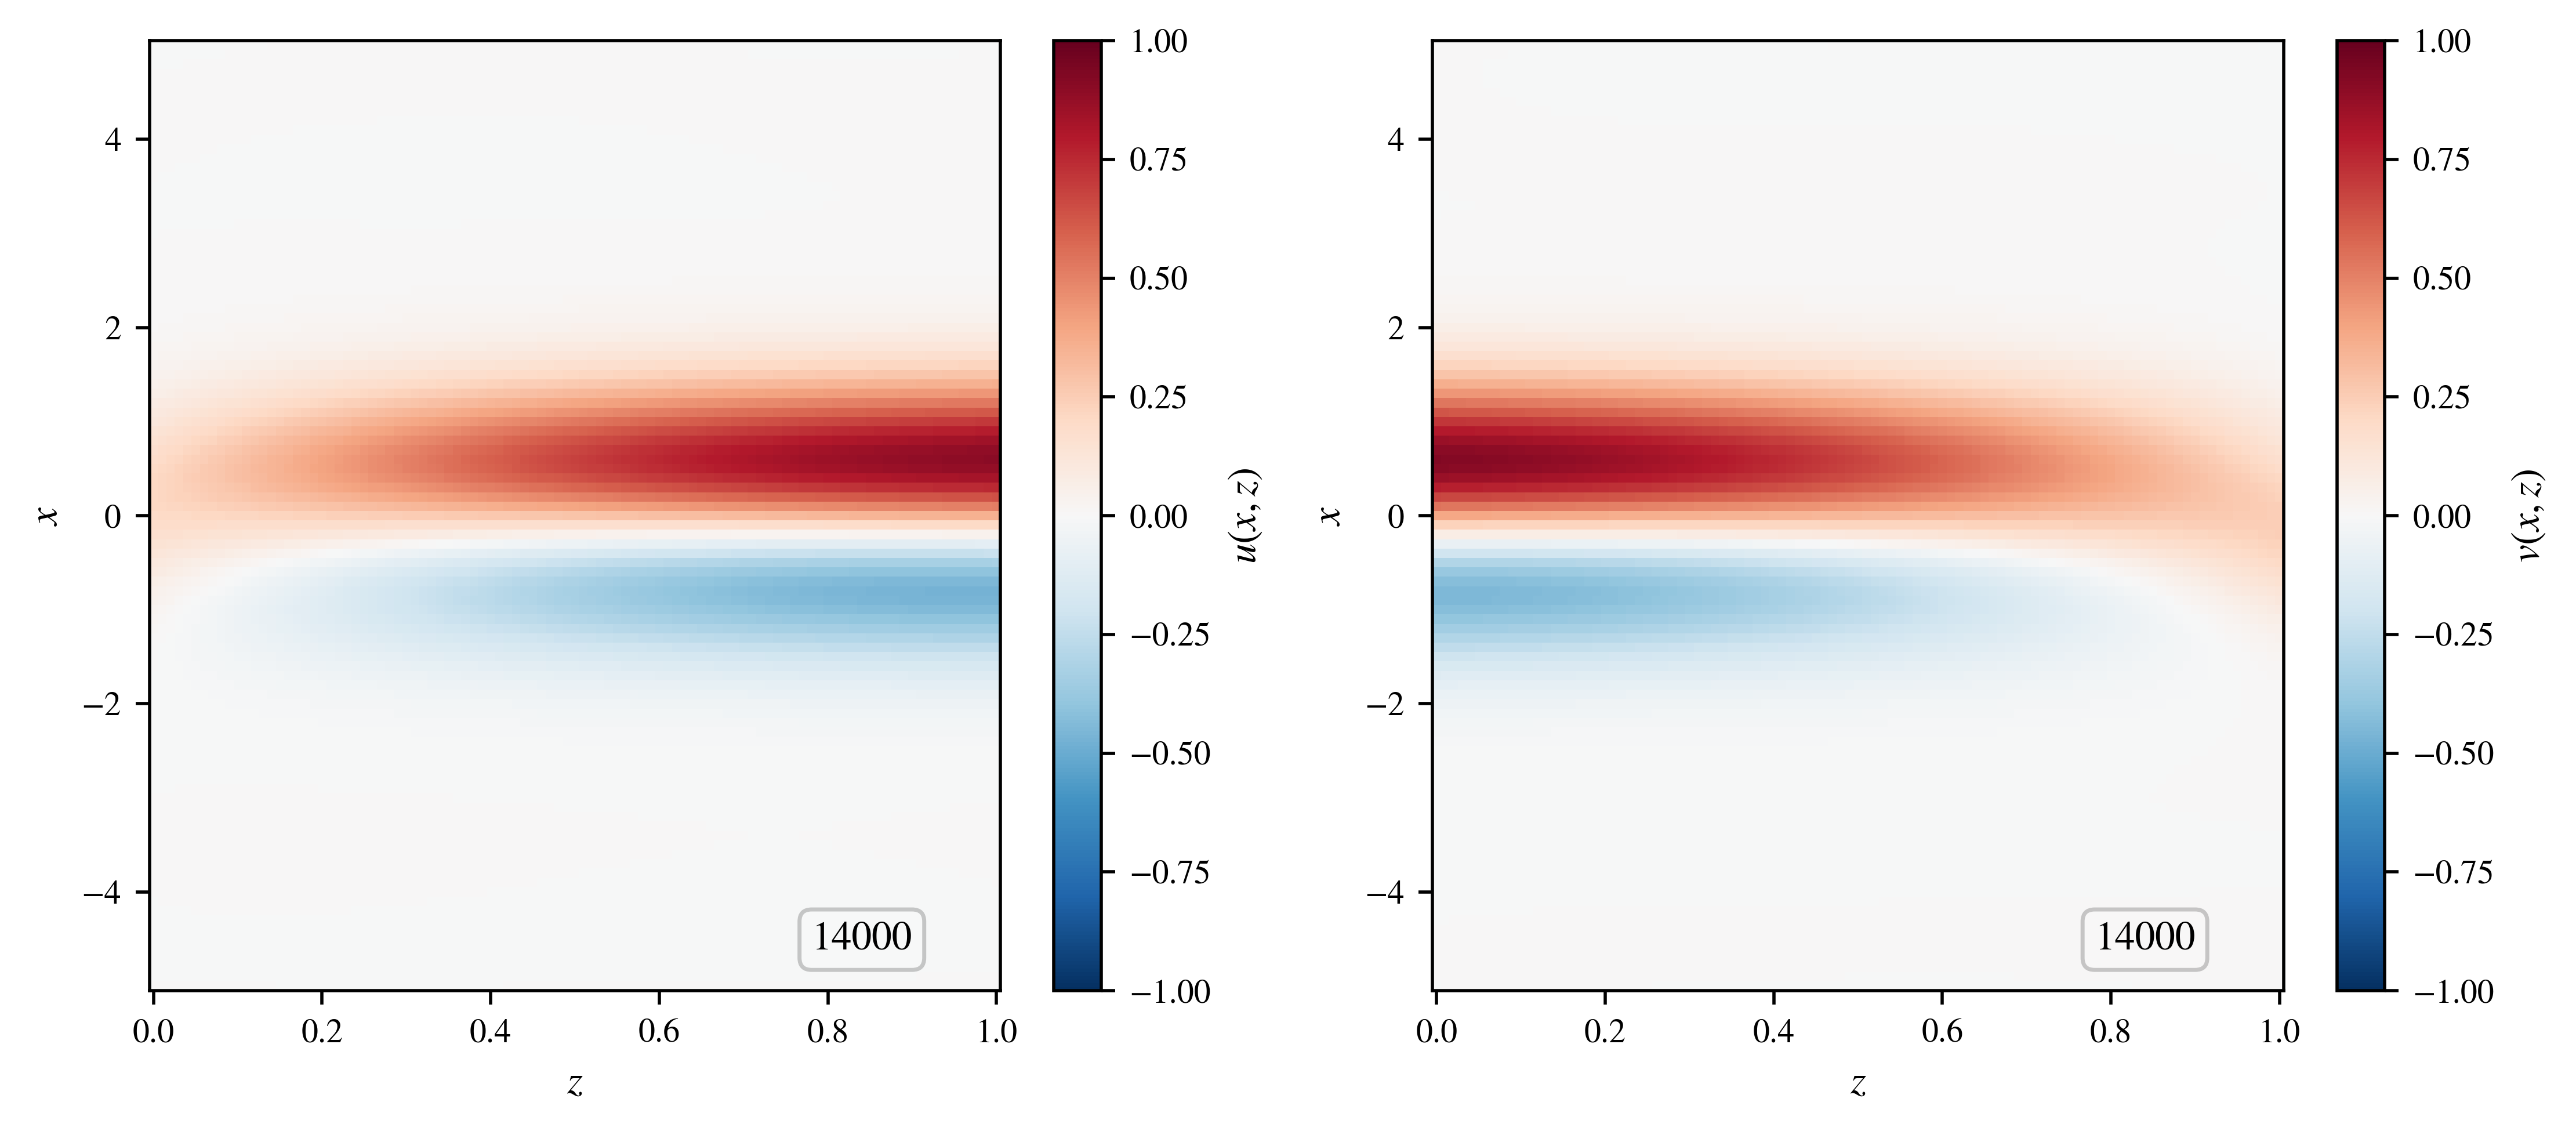

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4), dpi=500)
line1 = ax1.pcolormesh(ztestm, xtestm, u_plot, cmap = cm.RdBu_r, vmin=-1, vmax=1)
cbar1 = fig.colorbar(line1, ax=ax1)
cbar1.set_label(r'$u(x,z)$')
ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'$x$')
ax1.text(z_ub - 0.1, x_lb + 0.3, str(epoch), fontsize=10,
       verticalalignment='bottom', horizontalalignment='right', bbox=props)

line2 = ax2.pcolormesh(ztestm, xtestm, v_plot, cmap = cm.RdBu_r, vmin=-1, vmax=1)
cbar2 = fig.colorbar(line2, ax=ax2)
cbar2.set_label(r'$v(x,z)$')
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$x$')
ax2.text(z_ub - 0.1, x_lb + 0.3, str(epoch), fontsize=10,
       verticalalignment='bottom', horizontalalignment='right', bbox=props)

fig.tight_layout()
plt.show()
plt.close()

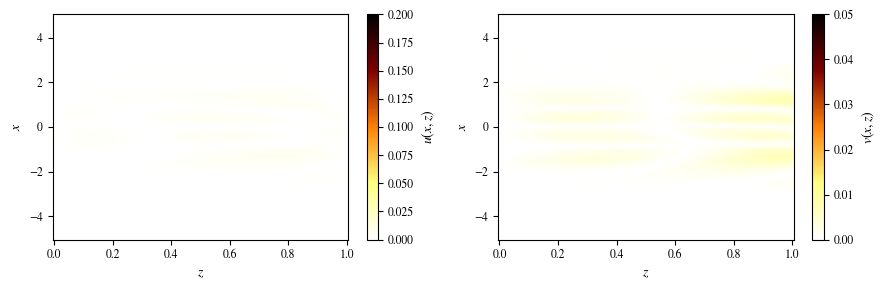

In [44]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,3), dpi=100)
line1 = ax1.pcolormesh(ztestm, xtestm, np.abs(u_plot - u_comp), cmap = cm.afmhot_r, vmin=0, vmax=0.2)
cbar1 = fig.colorbar(line1, ax=ax1)
cbar1.set_label(r'$u(x,z)$')
ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'$x$')
line2 = ax2.pcolormesh(ztestm, xtestm, np.abs(v_plot - v_comp), cmap = cm.afmhot_r, vmin=0, vmax=0.05)
cbar2 = fig.colorbar(line2, ax=ax2)
cbar2.set_label(r'$v(x,z)$')
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$x$')
fig.tight_layout()
plt.show()
plt.close()

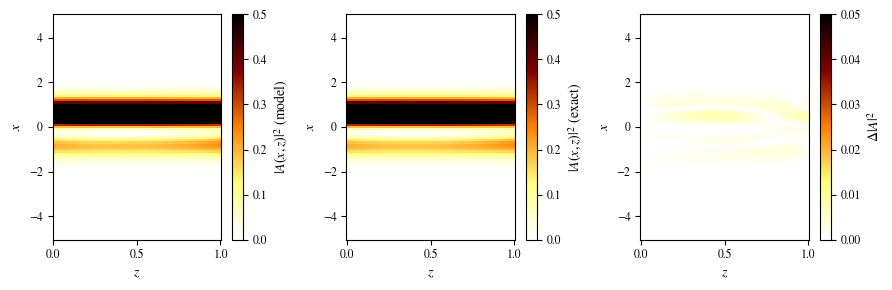

In [45]:
fig, (ax2, ax3, ax1) = plt.subplots(1,3, figsize=(9,3), dpi=100)
line1 = ax1.pcolormesh(ztestm, xtestm, np.abs(u_plot**2 + v_plot**2 - u_comp**2 - v_comp**2), cmap = cm.afmhot_r, vmin=0, vmax=0.05)
cbar1 = fig.colorbar(line1, ax=ax1)
cbar1.set_label(r'$\Delta |A|^2$')
ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'$x$')

line3 = ax3.pcolormesh(ztestm, xtestm, u_comp**2 + v_comp**2, cmap = cm.afmhot_r, vmin=0, vmax=.5)
cbar3 = fig.colorbar(line3, ax=ax3)
cbar3.set_label(r'$|A(x,z)|^2$ (exact)')
ax3.set_xlabel(r'$z$')
ax3.set_ylabel(r'$x$')

line2 = ax2.pcolormesh(ztestm, xtestm, u_plot**2 + v_plot**2, cmap = cm.afmhot_r, vmin=0, vmax=.5)
cbar2 = fig.colorbar(line2, ax=ax2)
cbar2.set_label(r'$|A(x,z)|^2$ (model)')
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$x$')

fig.tight_layout()
plt.show()
plt.close()

# Checklist of bugfixing

### check physics

- [x] PDEs correct?
- [x] implementation correct?

### check code

- [x] plotting correct?
- [x] check every damn line of code (yay)

### does it work?

- [x] yes